In [ ]:
# Make a way to create random zero sum games (for each a, u1 + u2 = 0)

# Iterate the games to simulate ficticious play

# When convergence?

# If they’re exactly tied, follow whatever tie‑break rule you’ve agreed on.


 # If they’re exactly tied, follow whatever tie‑break rule you’ve agreed on.



# Generate game,
# have starting point

# visualize convergence belief



Introduction

(note the theory)

(method)

Explain game choice,

Explain result,

Explain visualization

In [3]:
import nashpy as nash
import numpy as np

# 1) Define your payoff matrices.
#    Here’s the non‑zero‑sum example we used earlier:
A = np.array([[2, 0],
              [0, 4]])   # Row‐player payoff
B = np.array([[8, 0],
              [0, 8]])   # Column‐player payoff

game = nash.Game(A, B)

# 2) Decide how many rounds you want to run.
T = 200

# 3) Call the fictitious_play initializer.
#    You can optionally supply an initial pure/mixed strategy for each
#    player.  By default it starts at the uniform mix.
fp_iter = game.fictitious_play(
    iterations=T,
    initial_strategy=(
        np.array([1, 0]),      # row starts by playing “T” for sure
        np.array([1, 0])       # col starts by playing “L” for sure
    )
)

# 4) Pre‑allocate arrays to hold the beliefs at each t.
#    row_beliefs[t] will be the row‐player’s empirical mix *after*
#    round t+1 (because NashPy returns the updated mix each iteration).
row_beliefs = np.zeros((T, A.shape[0]))
col_beliefs = np.zeros((T, B.shape[1]))

# 5) Run the loop and fill your arrays.
for t, (x_t, y_t) in enumerate(fp_iter):
    # x_t is row’s belief over {T,B} at round t+1
    # y_t is col’s belief over {L,R} at round t+1
    row_beliefs[t, :] = x_t
    col_beliefs[t, :] = y_t

# Now you’ve recorded every belief profile.
# For instance, after 50 rounds:
print("Row belief @ t=50:", row_beliefs[49])
print("Col belief @ t=50:", col_beliefs[49])


TypeError: Game.fictitious_play() got an unexpected keyword argument 'initial_strategy'

In [4]:
import nashpy as nash
import numpy as np

# 1) Payoff matrices
A = np.array([[2, 0],
              [0, 4]])
B = np.array([[8, 0],
              [0, 8]])

game = nash.Game(A, B)

# 2) Number of rounds
T = 200

# 3) Use `initial_actions=(i,j)` instead of `initial_strategy`
#    Here 0 means “row plays T” and 0 means “col plays L” in our ordering.
fp_iter = game.fictitious_play(
    iterations=T,
    initial_actions=(0, 0)
)

# 4) Pre‑allocate belief arrays
row_beliefs = np.zeros((T, A.shape[0]))
col_beliefs = np.zeros((T, B.shape[1]))

# 5) Run the iterator
for t, (x_t, y_t) in enumerate(fp_iter):
    row_beliefs[t, :] = x_t
    col_beliefs[t, :] = y_t

print("Row belief @ t=50:", row_beliefs[49])
print("Col belief @ t=50:", col_beliefs[49])


TypeError: Game.fictitious_play() got an unexpected keyword argument 'initial_actions'

In [7]:
import nashpy as nash
import numpy as np

# 1) Payoff matrices
A = np.array([[2, 0],
              [0, 4]])
B = np.array([[8, 0],
              [0, 8]])

game = nash.Game(A, B)

# 2) Number of rounds
T = 200

# 3) Correct call: use `initial_actions=(0, 0)` instead of initial_strategy
#    This says “in round 0, row plays action 0 (T), column plays action 0 (L).”
fp_iter = game.fictitious_play(
    iterations=T,
    initial_actions=(0, 0)
)

# 4) Pre‑allocate arrays for beliefs
row_beliefs = np.zeros((T, A.shape[0]))
col_beliefs = np.zeros((T, B.shape[1]))

# 5) Run the iterator and record
for t, (x_t, y_t) in enumerate(fp_iter):
    row_beliefs[t, :] = x_t
    col_beliefs[t, :] = y_t

# Check
print("Row belief @ t=50:", row_beliefs[49])
print("Col belief @ t=50:", col_beliefs[49])


TypeError: Game.fictitious_play() got an unexpected keyword argument 'initial_actions'

In [9]:
import numpy as np


class FictitiousPlay:
    def __init__(self, A: np.ndarray, B: np.ndarray, initial_actions=(0, 0)):
        """
        A: row-player payoff matrix of size (n, m)
        B: col-player payoff matrix of size (n, m)
        initial_actions: a tuple (i0, j0) of pure actions to play in round 0,
                         where 0 <= i0 < n and 0 <= j0 < m.
        """
        self.A = A
        self.B = B
        self.n, self.m = A.shape

        # initialize counts and history
        self.counts_row = np.zeros(self.n)
        self.counts_col = np.zeros(self.m)

        # seed with the initial joint action
        i0, j0 = initial_actions
        self.counts_row[i0] += 1
        self.counts_col[j0] += 1

        # history stores tuples of (row_belief, col_belief, chosen_actions)
        self.history = [(
            # after round 0, beliefs are point‐mass on initial_actions
            self.counts_row / self.counts_row.sum(),
            self.counts_col / self.counts_col.sum(),
            (i0, j0)
        )]

    def best_response_row(self, y: np.ndarray) -> int:
        """Given col’s mixed y, return row‐player’s best pure response index."""
        # expected payoff of each row i = A[i,:] · y
        ev = self.A.dot(y)
        return int(np.argmax(ev))

    def best_response_col(self, x: np.ndarray) -> int:
        """Given row’s mixed x, return col‐player’s best pure response index."""
        # expected payoff of each col j = x · B[:,j]
        ev = x.dot(self.B)
        return int(np.argmax(ev))

    def run(self, T: int):
        """Run T additional rounds of fictitious play."""
        for _ in range(T):
            # current beliefs
            x = self.counts_row / self.counts_row.sum()
            y = self.counts_col / self.counts_col.sum()

            # best‐response actions
            i = self.best_response_row(y)
            j = self.best_response_col(x)

            # update counts
            self.counts_row[i] += 1
            self.counts_col[j] += 1

            # store new beliefs + actions
            x_new = self.counts_row / self.counts_row.sum()
            y_new = self.counts_col / self.counts_col.sum()
            self.history.append((x_new, y_new, (i, j)))

    def get_history(self):
        """Returns three arrays: row_beliefs, col_beliefs, actions."""
        T = len(self.history)
        row_beliefs = np.zeros((T, self.n))
        col_beliefs = np.zeros((T, self.m))
        actions = []
        for t, (xr, yc, act) in enumerate(self.history):
            row_beliefs[t, :] = xr
            col_beliefs[t, :] = yc
            actions.append(act)
        return row_beliefs, col_beliefs, actions


# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    # Payoff matrices from your non-zero-sum example
    A = np.array([[2, 0],
                  [0, 4]])   # row payoffs
    B = np.array([[8, 0],
                  [0, 8]])   # column payoffs

    # Initialize FP process with both playing action 0 at t=0
    fp = FictitiousPlay(A, B, initial_actions=(0, 0))

    # Run 200 more rounds
    fp.run(T=200)

    # Extract full history
    row_beliefs, col_beliefs, actions = fp.get_history()

    print(row_beliefs)

    print(col_beliefs)

    # Inspect e.g. beliefs at round 50
    print("Round 50 row belief:", row_beliefs[50])
    print("Round 50 col belief:", col_beliefs[50])
    print("Round 50 joint action:", actions[50])


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

In [ ]:
# Create the start board

# Create the players


# Each player contains: belief_other

# 


# Player
    # Other_history
    # Other_play

# Game
    # Class board
    # list_action_profiles_played

# Board.run
    # Apply action
    # Player1.update_blief
    # Player1.play
    # Player2.play


# Ficticiousplay
    # Board
        # Initialize(): need everything at once
            # Assert if its zero sum
            # Calculate equilibrium?
            # Player1: actions
            # Player2: actions
        # Play_actions()
    # H_action_history
    # Player1: believe_player2
    # Player2: believe_player3

    # Play_round
        # Get belief() 
        # Play actions()

In [11]:
import nashpy as nash
import numpy as np

A = np.array([[1, -1], [-1, 1]])
B = np.array([[1, -1], [-1, 1]])

game = nash.Game(A, B)
equilibria = list(game.support_enumeration())
print(equilibria)


[(array([1., 0.]), array([1., 0.])), (array([0., 1.]), array([0., 1.])), (array([0.5, 0.5]), array([0.5, 0.5]))]


In [ ]:


def run_game_iteration():
    

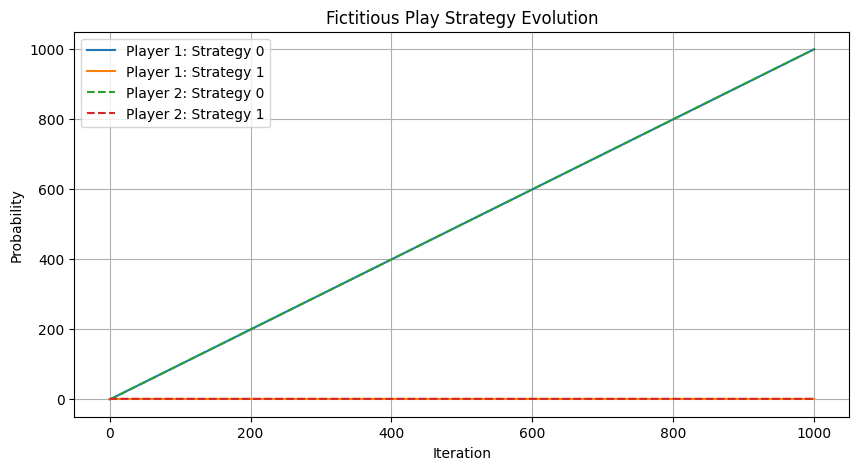

In [12]:
import nashpy as nash
import numpy as np
import matplotlib.pyplot as plt

# Define payoff matrices
A = np.array([[1, -1],
              [-1, 1]])
B = np.array([[1, -1],
              [-1, 1]])

# Create the game
game = nash.Game(A, B)

# Run fictitious play for N iterations
iterations = 1000
fict_play_generator = game.fictitious_play(iterations=iterations)

# Collect strategy distributions over time
player1_history = []
player2_history = []

for p1_strategy, p2_strategy in fict_play_generator:
    player1_history.append(p1_strategy)
    player2_history.append(p2_strategy)

# Convert to arrays for easier plotting
player1_history = np.array(player1_history)
player2_history = np.array(player2_history)

# Plot the evolution of strategies
plt.figure(figsize=(10, 5))
plt.plot(player1_history[:, 0], label="Player 1: Strategy 0")
plt.plot(player1_history[:, 1], label="Player 1: Strategy 1")
plt.plot(player2_history[:, 0], '--', label="Player 2: Strategy 0")
plt.plot(player2_history[:, 1], '--', label="Player 2: Strategy 1")
plt.title("Fictitious Play Strategy Evolution")
plt.xlabel("Iteration")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()


<generator object fictitious_play at 0x000001AA188C1690>


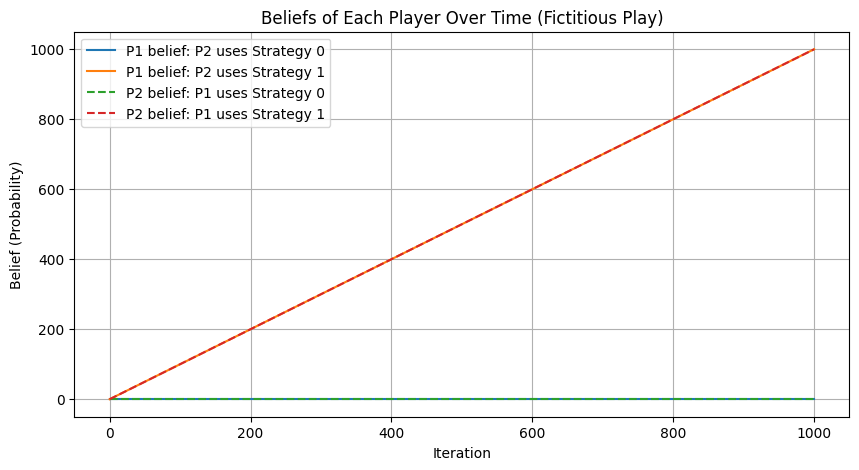

In [15]:
import nashpy as nash
import numpy as np
import matplotlib.pyplot as plt

# Define payoff matrices
A = np.array([[1, -1],
              [-1, 1]])
B = np.array([[1, -1],
              [-1, 1]])

# Create the game
game = nash.Game(A, B)

# Run fictitious play
iterations = 1000
fict_play_generator = game.fictitious_play(iterations=iterations)

print(fict_play_generator)

# Store beliefs (empirical distributions)
player1_beliefs = []  # What P1 believes about P2
player2_beliefs = []  # What P2 believes about P1

for p1_belief, p2_belief in fict_play_generator:
    player1_beliefs.append(p1_belief)
    player2_beliefs.append(p2_belief)

# Convert to arrays
player1_beliefs = np.array(player1_beliefs)
player2_beliefs = np.array(player2_beliefs)

# Plot beliefs
plt.figure(figsize=(10, 5))
plt.plot(player1_beliefs[:, 0], label="P1 belief: P2 uses Strategy 0")
plt.plot(player1_beliefs[:, 1], label="P1 belief: P2 uses Strategy 1")
plt.plot(player2_beliefs[:, 0], '--', label="P2 belief: P1 uses Strategy 0")
plt.plot(player2_beliefs[:, 1], '--', label="P2 belief: P1 uses Strategy 1")
plt.title("Beliefs of Each Player Over Time (Fictitious Play)")
plt.xlabel("Iteration")
plt.ylabel("Belief (Probability)")
plt.legend()
plt.grid(True)
plt.show()


<generator object fictitious_play at 0x000001AA188C0040>


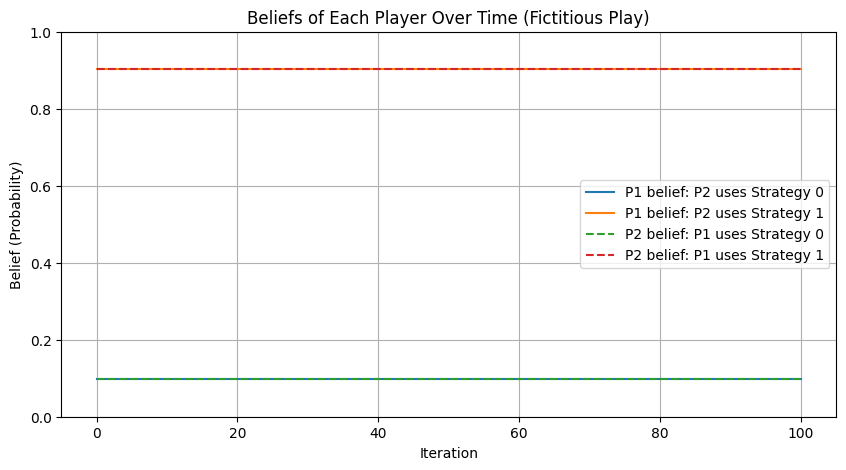

In [ ]:
import nashpy as nash
import numpy as np
import matplotlib.pyplot as plt

# Define payoff matrices
A = np.array([[1, -1],
              [-1, 1]])
B = np.array([[1, -1],
              [-1, 1]])

# Create the game
game = nash.Game(A, B)

# Specify starting play counts (e.g., both start with 1 play of each strategy)
initial_play_counts = (
    np.array([1, 1], dtype=float),  # Player 1's initial belief about P2
    np.array([1, 1], dtype=float)   # Player 2's initial belief about P1
)

# Run fictitious play
iterations = 100
fict_play_generator = game.fictitious_play(iterations=iterations, play_counts=initial_play_counts)

# Store normalized beliefs
player1_beliefs = []
player2_beliefs = []

print(fict_play_generator)

for p1_counts, p2_counts in fict_play_generator:
    # Normalize the counts to get beliefs (probabilities)
    p1_belief = p1_counts / np.sum(p1_counts)
    p2_belief = p2_counts / np.sum(p2_counts)
    player1_beliefs.append(p1_belief)
    player2_beliefs.append(p2_belief)

# Convert to arrays
player1_beliefs = np.array(player1_beliefs)
player2_beliefs = np.array(player2_beliefs)

# Plot beliefs over time
plt.figure(figsize=(10, 5))
plt.plot(player1_beliefs[:, 0], label="P1 belief: P2 uses Strategy 0")
plt.plot(player1_beliefs[:, 1], label="P1 belief: P2 uses Strategy 1")
plt.plot(player2_beliefs[:, 0], '--', label="P2 belief: P1 uses Strategy 0")
plt.plot(player2_beliefs[:, 1], '--', label="P2 belief: P1 uses Strategy 1")
plt.title("Beliefs of Each Player Over Time (Fictitious Play)")
plt.xlabel("Iteration")
plt.ylabel("Belief (Probability)")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


In [39]:
import nashpy as nash

import numpy as np

A = np.array([[1, -1],
              [-1, 1]])
B = np.array([[-1, 1],
              [1, -1]])

game = nash.Game(A, B)
print(game)

equilibria = list(game.support_enumeration())
print(equilibria)

Zero sum game with payoff matrices:

Row player:
[[ 1 -1]
 [-1  1]]

Column player:
[[-1  1]
 [ 1 -1]]
[(array([0.5, 0.5]), array([0.5, 0.5]))]


C:\Users\Saloc\AppData\Local\Temp\ipykernel_14028\3888078739.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  row_beliefs.append(row_play_counts[1]/row_play_counts[0])
C:\Users\Saloc\AppData\Local\Temp\ipykernel_14028\3888078739.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  col_beliefs.append(col_play_counts[1]/col_play_counts[0])


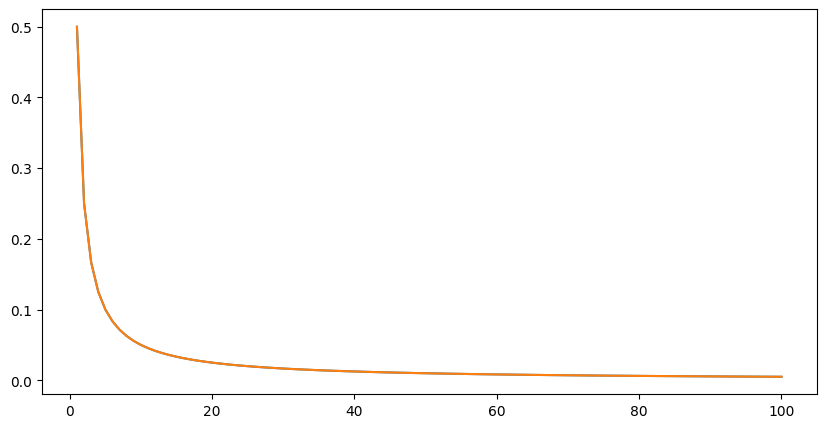

In [ ]:
np.random.seed(3)

iterations = 1000

play_counts = game.fictitious_play(iterations=iterations)
col_beliefs = []
row_beliefs = []
for row_play_counts, col_play_counts in play_counts:
    row_beliefs.append(row_play_counts[1]/row_play_counts[0])
    col_beliefs.append(col_play_counts[1]/col_play_counts[0])


# Plot beliefs over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(col_beliefs)), col_beliefs, label="col beliefs")
plt.plot(range(len(row_beliefs)), row_beliefs, label='row_beliefs')
plt.show()

[(array([0., 1.]), array([1., 0.]))]
10001
2


C:\Users\Saloc\AppData\Local\Temp\ipykernel_14028\2999883802.py:22: RuntimeWarning: invalid value encountered in divide
  sigma_row.append(row_play_counts / row_play_counts.sum())
C:\Users\Saloc\AppData\Local\Temp\ipykernel_14028\2999883802.py:24: RuntimeWarning: invalid value encountered in divide
  sigma_col.append(col_play_counts / col_play_counts.sum())


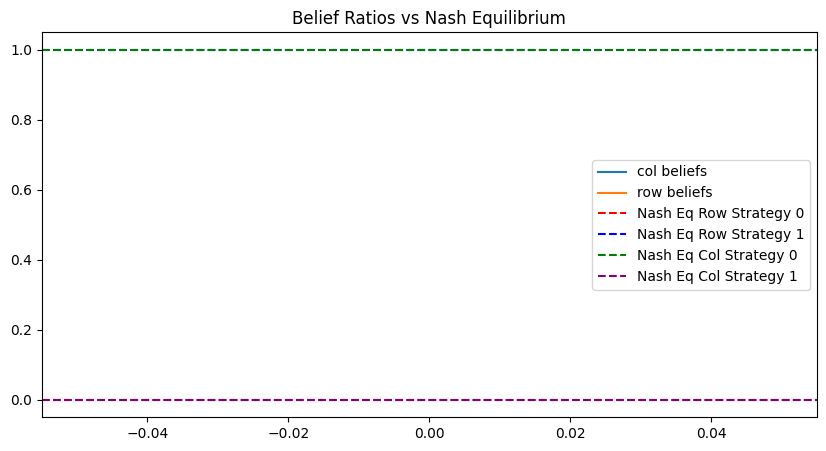

In [354]:
import numpy as np


m, n = 2, 2
# e.g. uniform on [0,1)
A = np.random.rand(m, n)
game = nash.Game(A)
assert game.zero_sum == True

equilibria = list(game.support_enumeration())
print(equilibria)

iterations = 10000

play_counts = game.fictitious_play(iterations=iterations)
sigma_row = []
sigma_col = []


# print(row_play_counts, col_play_counts)
for row_play_counts, col_play_counts in play_counts:
    sigma_row.append(row_play_counts / row_play_counts.sum())
    # print(sigma_row)
    sigma_col.append(col_play_counts / col_play_counts.sum())

print(len(sigma_col))

print(len(row_play_counts))
# Plot beliefs over time
plt.figure(figsize=(10, 5))
plt.plot(iterations, sigma_col[0][1:], label="col beliefs")
plt.plot(iterations, sigma_row[0][1:], label="row beliefs")
# Add horizontal lines showing the equilibrium strategies
for eq in equilibria:
    plt.axhline(eq[0][0], color='red', linestyle='--', label="Nash Eq Row Strategy 0")
    plt.axhline(eq[0][1], color='blue', linestyle='--', label="Nash Eq Row Strategy 1")
    plt.axhline(eq[1][0], color='green', linestyle='--', label="Nash Eq Col Strategy 0")
    plt.axhline(eq[1][1], color='purple', linestyle='--', label="Nash Eq Col Strategy 1")
plt.title("Belief Ratios vs Nash Equilibrium")
plt.legend()
plt.show()


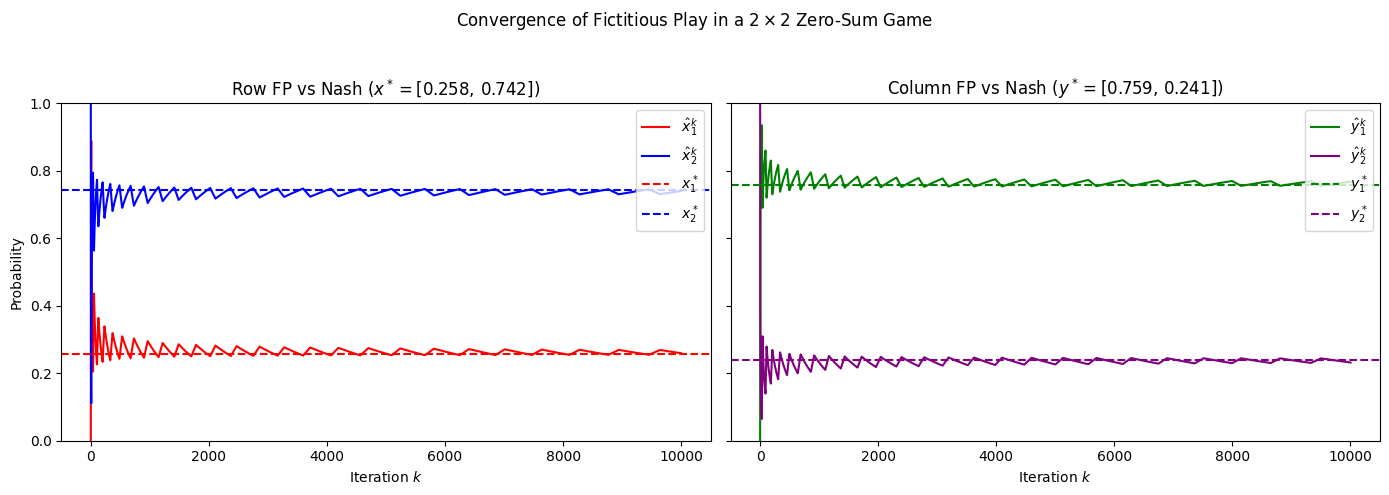

In [645]:
import numpy as np
import matplotlib.pyplot as plt
import nashpy as nash

# 1) Build a random 2×2 zero‐sum game
np.random.seed(0)
A = np.random.rand(2, 2) * 10
game = nash.Game(A)  # payoff_matrices = (A, -A)
assert game.zero_sum

# 2) Compute the unique mixed Nash equilibrium
#    x* = (x*_1, x*_2),  y* = (y*_1, y*_2)
x_star, y_star = list(game.support_enumeration())[0]
x1_star, x2_star = x_star
y1_star, y2_star = y_star

# 3) Run FP for K iterations and collect the raw play counts
K = 10000
fp_plays = list(game.fictitious_play(iterations=K))

# 4) Stack counts and drop the initial [0,0] at k=0
row_counts = np.stack([rc for rc, _ in fp_plays], axis=0)[1:]
col_counts = np.stack([cc for _, cc in fp_plays], axis=0)[1:]

# 5) Convert counts → empirical mixes
#    \hat x^k_i = row_counts[k,i] / sum(row_counts[k,:])
#    \hat y^k_j = col_counts[k,j] / sum(col_counts[k,:])
x_hat = row_counts / row_counts.sum(axis=1, keepdims=True)
y_hat = col_counts / col_counts.sum(axis=1, keepdims=True)

# 6) Plotting
t = np.arange(1, K + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Row‐player subplot (x‐process) ---
ax[0].plot(t, x_hat[:, 0], color="red",   label=r"$\hat x^k_1$")
ax[0].plot(t, x_hat[:, 1], color="blue",  label=r"$\hat x^k_2$")
ax[0].axhline(x1_star, color="red",   linestyle="--", label=r"$x^*_1$")
ax[0].axhline(x2_star, color="blue",  linestyle="--", label=r"$x^*_2$")
ax[0].set_title(
    rf"Row FP vs Nash ($x^*=[{x1_star:.3f},\,{x2_star:.3f}]$)"
)
ax[0].set_xlabel(r"Iteration $k$")
ax[0].set_ylabel(r"Probability")
ax[0].legend(loc="upper right")
ax[0].set_ylim(0, 1)

# --- Column‐player subplot (y‐process) ---
ax[1].plot(t, y_hat[:, 0], color="green",   label=r"$\hat y^k_1$")
ax[1].plot(t, y_hat[:, 1], color="purple",  label=r"$\hat y^k_2$")
ax[1].axhline(y1_star, color="green",   linestyle="--", label=r"$y^*_1$")
ax[1].axhline(y2_star, color="purple",  linestyle="--", label=r"$y^*_2$")
ax[1].set_title(
    rf"Column FP vs Nash ($y^*=[{y1_star:.3f},\,{y2_star:.3f}]$)"
)
ax[1].set_xlabel(r"Iteration $k$")
ax[1].legend(loc="upper right")
ax[1].set_ylim(0, 1)

plt.suptitle(r"Convergence of Fictitious Play in a $2\times 2$ Zero‐Sum Game")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


Converged (below ε=0.01) for 100 steps from k = 3125


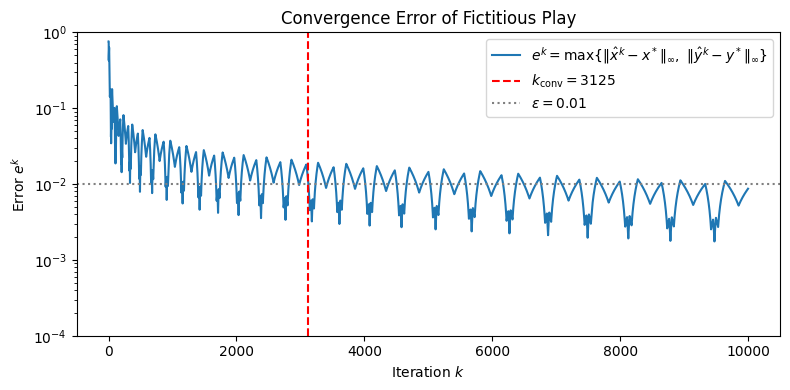

In [664]:
import numpy as np
import matplotlib.pyplot as plt
import nashpy as nash

# 1) Build a random 2×2 zero‐sum game
np.random.seed(0)
A    = np.random.rand(2, 2)
game = nash.Game(A)
# equilibrium mixes x* = (x*_1, x*_2), y* = (y*_1, y*_2)
x_star, y_star = list(game.support_enumeration())[0]
x1_star, x2_star = x_star
y1_star, y2_star = y_star

# 2) Run FP for K rounds and collect play‐counts
K = 10000
fp_plays = list(game.fictitious_play(iterations=K))

# 3) Build empirical mixes \hat x^k and \hat y^k
#    drop the initial zero‐count at k=0
row_counts = np.stack([rc for rc, _ in fp_plays], axis=0)[1:]
col_counts = np.stack([cc for _, cc in fp_plays], axis=0)[1:]
x_hat = row_counts / row_counts.sum(axis=1, keepdims=True)
y_hat = col_counts / col_counts.sum(axis=1, keepdims=True)

# 4) Compute per‐round max‐norm errors
#    e^k_x = ||\hat x^k - x*||_∞,  e^k_y = ||\hat y^k - y*||_∞
e_x = np.max(np.abs(x_hat - x_star), axis=1)
e_y = np.max(np.abs(y_hat - y_star), axis=1)
# combined error e^k = max(e^k_x, e^k_y)
e   = np.maximum(e_x, e_y)

# 5) Find the first iteration where e^k stays below ε for a window
epsilon     = 1e-2
window_size = 100
converged_at = None
for k in range(len(e) - window_size):
    if np.all(e[k : k + window_size] < epsilon):
        # +1 because our e[0] corresponds to k=1 in the play sequence
        converged_at = k + 1
        break

print(f"Converged (below ε={epsilon}) for {window_size} steps from k =",
      converged_at)

# 6) Plot error curve
plt.figure(figsize=(8, 4))
plt.semilogy(
    np.arange(1, K + 1),
    e,
    label=r"$e^k = \max\{\|\hat x^k - x^*\|_\infty,\ \|\hat y^k - y^*\|_\infty\}$"
)
# vertical line at convergence
if converged_at is not None:
    plt.axvline(
        converged_at,
        color="red",
        linestyle="--",
        label=rf"$k_{{\mathrm{{conv}}}} = {converged_at}$"
    )
# horizontal tolerance line
plt.axhline(
    epsilon,
    color="gray",
    linestyle=":",
    label=rf"$\epsilon = {epsilon}$"
)

plt.xlabel("Iteration $k$")
plt.ylabel(r"Error $e^k$")
plt.title("Convergence Error of Fictitious Play")
plt.legend(loc="upper right")
plt.ylim(1e-4, 1)
plt.tight_layout()
plt.show()



Row errors hit ε=0.01 for 100 steps from k=1317
Col errors hit ε=0.01 for 100 steps from k=1170


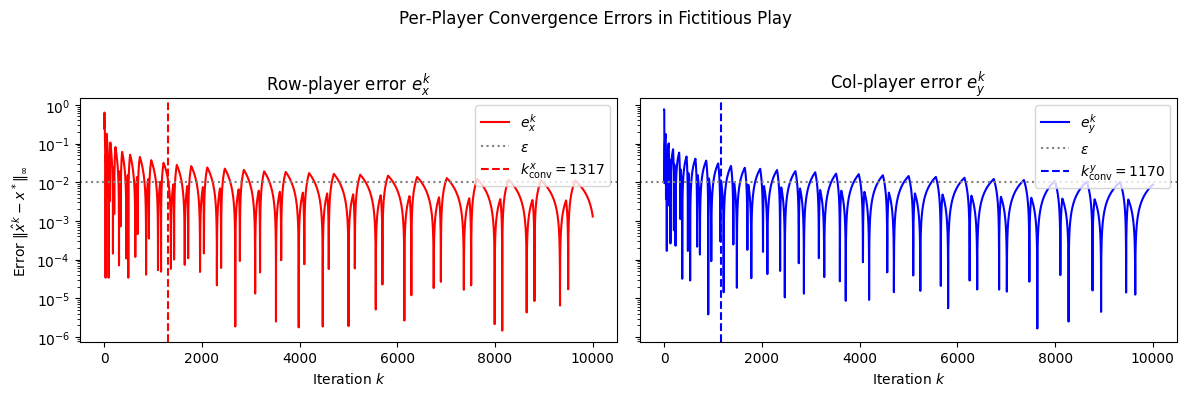

In [665]:
import numpy as np
import matplotlib.pyplot as plt
import nashpy as nash

# 1) Build a random 2×2 zero‐sum game
np.random.seed(0)
A    = np.random.rand(2, 2)
game = nash.Game(A)

# equilibrium mixes x* = (x*_1, x*_2), y* = (y*_1, y*_2)
x_star, y_star = list(game.support_enumeration())[0]

# 2) Run FP for K rounds
K = 10000
fp_plays = list(game.fictitious_play(iterations=K))

# 3) Build empirical mixes \hat x^k and \hat y^k
row_counts = np.stack([rc for rc, _ in fp_plays], axis=0)[1:]
col_counts = np.stack([cc for _, cc in fp_plays], axis=0)[1:]
x_hat = row_counts / row_counts.sum(axis=1, keepdims=True)
y_hat = col_counts / col_counts.sum(axis=1, keepdims=True)

# 4) Compute per‐round infinity‐norm errors
e_x = np.max(np.abs(x_hat - x_star), axis=1)
e_y = np.max(np.abs(y_hat - y_star), axis=1)

# 5) Convergence thresholds
epsilon     = 1e-2
window_size = 100

def first_hitting(err, ε, w):
    """Return the first k (1-based) such that err[k-1 : k-1+w] < ε."""
    for k in range(len(err) - w):
        if np.all(err[k : k + w] < ε):
            return k + 1
    return None

k_conv_x = first_hitting(e_x, epsilon, window_size)
k_conv_y = first_hitting(e_y, epsilon, window_size)

print("Row errors hit ε=%.2g for %d steps from k=%s" %
      (epsilon, window_size, k_conv_x))
print("Col errors hit ε=%.2g for %d steps from k=%s" %
      (epsilon, window_size, k_conv_y))

# 6) Plot both error‐processes in separate subplots
t = np.arange(1, K + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# -- Row error panel
ax[0].semilogy(t, e_x, color="red", label=r"$e_x^k$")
ax[0].axhline(epsilon, color="gray", linestyle=":", label=r"$\varepsilon$")
if k_conv_x:
    ax[0].axvline(k_conv_x, color="red", linestyle="--",
                  label=rf"$k^x_{{\rm conv}}={k_conv_x}$")
ax[0].set_title(r"Row‐player error $e_x^k$")
ax[0].set_xlabel(r"Iteration $k$")
ax[0].set_ylabel(r"Error $\|\hat x^k - x^*\|_\infty$")
ax[0].legend(loc="upper right")

# -- Column error panel
ax[1].semilogy(t, e_y, color="blue", label=r"$e_y^k$")
ax[1].axhline(epsilon, color="gray", linestyle=":", label=r"$\varepsilon$")
if k_conv_y:
    ax[1].axvline(k_conv_y, color="blue", linestyle="--",
                  label=rf"$k^y_{{\rm conv}}={k_conv_y}$")
ax[1].set_title(r"Col‐player error $e_y^k$")
ax[1].set_xlabel(r"Iteration $k$")
ax[1].legend(loc="upper right")

plt.suptitle("Per‑Player Convergence Errors in Fictitious Play")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
